In [29]:
import os
from pathlib import Path
from typing import Dict
from zipfile import ZipFile

from dotenv import find_dotenv, load_dotenv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from bokeh import plotting, models
from bokeh.io import output_notebook

output_notebook()
load_dotenv(find_dotenv())
DATA_ZIP = os.getenv('DATA_DIR_HAPPINESS')

Loading BokehJS ...

In [124]:
def read_data(zip_file: str) -> Dict[int, pd.DataFrame]:
    csv_files = dict()
    with ZipFile(zip_file) as zip_data:
        print(zip_data.namelist())
        for csv_file in zip_data.namelist():
            year = Path(csv_file).stem
            csv_files[int(year)] = pd.read_csv(zip_data.open(csv_file))
    
    return csv_files

def merge_data(all_data: Dict[int, pd.DataFrame]) -> pd.DataFrame:
    all_dfs = []
    columns_to_rename = [
        'Country', 'Score', 'Rank', 'GDP', 'Health', 'Corruption', 'Freedom',
        'Generosity'
    ]
    
    for year, dataframe in all_data.items():
        single_df = []
        for column_name in columns_to_rename:
            col = dataframe.columns.str.contains(column_name, case=False)
            if any(col):
                tmp_df = dataframe.loc[:, col]
                # print(year, tmp_df.columns)
                tmp_df.columns = [column_name]
                single_df.append(tmp_df)

        df_single_year = pd.concat(single_df, axis='columns')
        df_single_year['Year'] = year
        all_dfs.append(df_single_year)
    
    return pd.concat(all_dfs, axis='index', ignore_index=True)

In [125]:
all_data = read_data(zip_file=DATA_ZIP)

['2015.csv', '2016.csv', '2017.csv', '2018.csv', '2019.csv']


In [126]:
all_data_merged = merge_data(all_data=all_data)

In [127]:
all_data_merged.describe()

,Score,Rank,GDP,Health,Corruption,Freedom,Generosity,Year
count,782.000000,782.000000,782.000000,782.000000,781.000000,782.000000,782.000000,782.000000
mean,5.379018,78.698210,0.916047,0.612416,0.125436,0.411091,0.218576,2016.993606
std,1.127456,45.182384,0.407340,0.248309,0.105816,0.152880,0.122321,1.417364
min,2.693000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000
25%,4.509750,40.000000,0.606500,0.440183,0.054000,0.309768,0.130000,2016.000000
50%,5.322000,79.000000,0.982205,0.647310,0.091000,0.431000,0.201982,2017.000000
75%,6.189500,118.000000,1.236187,0.808000,0.156030,0.531000,0.278832,2018.000000
max,7.769000,158.000000,2.096000,1.141000,0.551910,0.724000,0.838075,2019.000000


#### Correlation Between Happiness Score and Other Factors

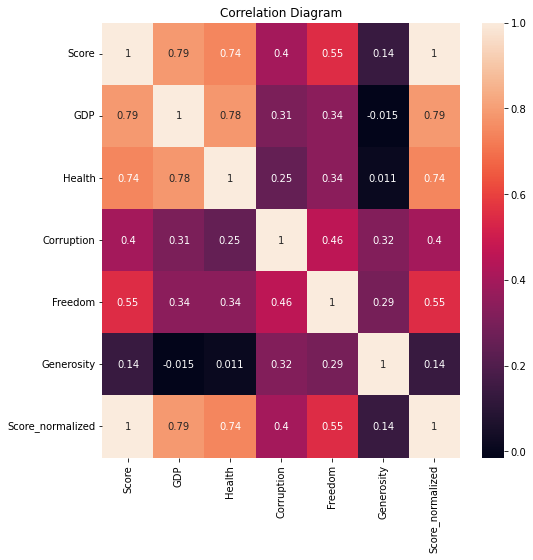

In [134]:
corr = all_data_merged.select_dtypes(include='float').corr()
figure, axes = plt.subplots(1,1, figsize=(8,8))
axes.set_title('Correlation Diagram')
seaborn.heatmap(corr, annot=True, ax=axes)
plt.show()

- GDP per capita and Health(Life Expectancy) columns are correlated with the happiness score in a strong positive way.
- There is a moderate positive correlation between Corruption, Freedom and the happiness score.
- There is a small correlation between Generosity and the happiness score.

GDP Per Capita and Life Expectancy play an important role for people's happiness

#### Bubble Charts

In [135]:
# Normalize Happiness score to use as bubbles' radius
numerator = (all_data_merged['Score'] - all_data_merged['Score'].min())
denominator = (all_data_merged['Score'].max() - all_data_merged['Score'].min())
all_data_merged['Score_normalized'] = 0.03 * (numerator / denominator)
source_2015 = models.ColumnDataSource(all_data_merged.set_index('Year').loc[2015, :])
source_2016 = models.ColumnDataSource(all_data_merged.set_index('Year').loc[2016, :])
source_2017 = models.ColumnDataSource(all_data_merged.set_index('Year').loc[2017, :])
source_2018 = models.ColumnDataSource(all_data_merged.set_index('Year').loc[2018, :])
source_2019 = models.ColumnDataSource(all_data_merged.set_index('Year').loc[2019, :])

In [137]:
x = 'GDP'
y = 'Health'
target = 'Score_normalized'
title = f'Happiness {target} with respect to {x} and {y} scores'
TOOL_TIPS = [
    ('Happiness', '@Score'),
    ('Country', '@Country'),
    ('(GDP, Health)', '($x, $y)'),
    ('Year', '@Year')
]
plot = plotting.figure(width=1200, height=400, title=title, tooltips=TOOL_TIPS)
# plot.scatter(x='GDP', y='Health', source=source_2015, size='Score', color='olive', alpha=0.4)
plot.circle(x=x, y=y, source=source_2015, color='olive', radius=target, alpha=0.4, legend_label='2015')
plot.circle(x=x, y=y, source=source_2016, color='blue', radius=target, alpha=0.4, legend_label='2016')
plot.circle(x=x, y=y, source=source_2017, color='cyan', radius=target, alpha=0.4, legend_label='2017')
plot.xaxis.axis_label = x
plot.yaxis.axis_label = y
plot.legend.click_policy = 'hide'

plotting.show(plot)

We can see that higher GDP per capita and Life expectancy indicates more happiness

#### Questions

1) Which countries have the best scores in terms of all the factors?

In [154]:
from collections import defaultdict
best = defaultdict(dict)

columns = ['Score', 'Health', 'Corruption', 'Freedom', 'Generosity']
years = [2015, 2016, 2017, 2018, 2019]
for year in years:
    for column in columns:
        country = all_data_merged.loc[all_data_merged['Year']==year, :]\
            .sort_values(by=column, ascending=False)\
            .reset_index(drop=True)\
            .iloc[0, 0]
        best[year][column] = country

In [157]:
best

defaultdict(dict,
            {2015: {'Score': 'Switzerland',
              'Health': 'Singapore',
              'Corruption': 'Rwanda',
              'Freedom': 'Norway',
              'Generosity': 'Myanmar'},
             2016: {'Score': 'Denmark',
              'Health': 'Hong Kong',
              'Corruption': 'Rwanda',
              'Freedom': 'Uzbekistan',
              'Generosity': 'Myanmar'},
             2017: {'Score': 'Norway',
              'Health': 'Singapore',
              'Corruption': 'Singapore',
              'Freedom': 'Uzbekistan',
              'Generosity': 'Myanmar'},
             2018: {'Score': 'Finland',
              'Health': 'Hong Kong',
              'Corruption': 'Singapore',
              'Freedom': 'Uzbekistan',
              'Generosity': 'Myanmar'},
             2019: {'Score': 'Finland',
              'Health': 'Singapore',
              'Corruption': 'Singapore',
              'Freedom': 'Uzbekistan',
              'Generosity': 'Myanmar'}})

- In terms of happiness score, Finland wins twice.
- In terms of Health (Life expectancy), Singapore wins 3 times.
- In terms of corruption, Singapore wins 3 times, interesting.
- In terms of Freedom, Uzbekistan wins 4 times.
- In terms of Generosity, Myanmar comes the first one for 5 consecutive years.

2) How did happiness scores change from 2016 to 2017?
- From looking at the bubble charts above, we can say that countries such as Qatar, Luxembourg, Singapore kept their places although their GDP and Life expectancy values increased.
- Countries such as Guinea and Liberia still have the least happy people.

3) Is there any country that had an important increase or decrease in their happiness score?
- From the below dataframe, we can see that the biggest change in happiness score occured for Venezuela

In [178]:
happiness_difference = all_data_merged.groupby(by=['Country'], as_index=False)\
    .agg(minimum=('Score', np.min), maximum=('Score', np.max))
happiness_difference['difference'] = happiness_difference['maximum'] - happiness_difference['minimum']
happiness_difference.sort_values(by='difference', ascending=False).reset_index(drop=True)

,Country,minimum,maximum,difference
0,Venezuela,4.707,6.810,2.103
1,Benin,3.340,4.883,1.543
2,Ivory Coast,3.655,4.944,1.289
3,Togo,2.839,4.085,1.246
4,Algeria,5.211,6.355,1.144
...,...,...,...,...
165,North Macedonia,5.274,5.274,0.000
166,Gambia,4.516,4.516,0.000
167,Trinidad & Tobago,6.192,6.192,0.000
168,"Hong Kong S.A.R., China",5.472,5.472,0.000
